# ⚛️ VQE Ground State Simulation of H₂: Noisy vs. Noiseless Comparison

This notebook first computes the VQE ground state of H₂ on a **noiseless statevector simulator** once for each random seed.
It then runs the same VQE procedure on a **noisy density-matrix simulator** for a range of noise strengths,
and compares:

- Energy convergence vs. the noiseless reference
- Final state populations
- Fidelity of each noisy ground state to the noiseless ground state


In [30]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import sys, os, json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.vqe_utils import excitation_ansatz, set_seed, get_optimizer, ensure_dirs, make_run_config_dict, run_signature, find_existing_run, save_run_record, build_run_filename, init_params
from src.vqe_utils import RESULTS_DIR, IMG_DIR, OPTIMIZERS, ANSATZES

# Create folders if needed
ensure_dirs()

# Seeds for repeated runs
seeds = np.arange(0, 5)

# Molecule info
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])
basis = "STO-3G"
electrons = 2

# Ansatz and optimizer
ansatz_desc = "TwoQubit-RY-CNOT"
optimizer_name = "Adam"
stepsize = 0.1
max_iterations = 50

# Build Hamiltonian and Hartree-Fock state
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

num_wires = qubits
singles, doubles = qchem.excitations(electrons, qubits)

# Different noise values
noise_levels = np.arange(0, 0.11, 0.02)


In [31]:
# Define VQE circuits - noisy and noiseless
def get_vqe_qnode(ansatz_fn=None, noisy=True, return_state=False,
                  depolarizing_prob=0.0, amplitude_damping_prob=0.0):
    dev_name = "default.mixed" if noisy else "default.qubit"
    dev = qml.device(dev_name, wires=num_wires)

    # Choose differentiation method based on whether noisy or not
    diff_method = "parameter-shift" if not noisy else "finite-diff"
    
    @qml.qnode(dev, diff_method=diff_method)
    def circuit(params):
        if ansatz_fn == excitation_ansatz:
            excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                              excitations=(singles, doubles), excitation_type="both")
        else:
            ansatz_fn(params, wires=range(num_wires))
        if noisy:
            for w in range(num_wires):
                qml.DepolarizingChannel(depolarizing_prob, wires=w)
                qml.AmplitudeDamping(amplitude_damping_prob, wires=w)
        return qml.state() if return_state else qml.expval(hamiltonian)

    return circuit


# Run VQE or load from cache
def run_vqe_with_cache(seed, noisy=True, dep_prob=0.0, amp_prob=0.0,
                               optimizer_name="Adam", ansatz_name=None):
    ansatz_fn = ANSATZES.get(ansatz_name, excitation_ansatz)
    set_seed(seed)

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_name or ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=noisy,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )

    sig = run_signature(cfg)
    fname = build_run_filename("H2_Noise_Error", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        energies = rec["energies"]
        params = np.array(rec["final_params"])
        final_state = np.array(rec.get("final_state_real", [])) + 1j * np.array(rec.get("final_state_imag", []))
    else:
        if ansatz_name is None or ansatz_name not in ANSATZES:
            n_params = len(singles) + len(doubles)
            params = 0.01 * np.random.randn(n_params)
        else:
            print(f"Using ansatz: {ansatz_name}")
            params = init_params(ansatz_name, num_wires=num_wires, scale=0.01)
        cost_fn = get_vqe_qnode(ansatz_fn=ansatz_fn, noisy=noisy, return_state=False,
                                depolarizing_prob=dep_prob, amplitude_damping_prob=amp_prob)
        opt = get_optimizer(optimizer_name, stepsize=stepsize)
        energies = [cost_fn(params)]
        for _ in range(max_iterations):
            params, e_prev = opt.step_and_cost(cost_fn, params)
            energies.append(e_prev)
        final_state = get_vqe_qnode(ansatz_fn=ansatz_fn, noisy=noisy, return_state=True,
                                    depolarizing_prob=dep_prob, amplitude_damping_prob=amp_prob)(params)
        rec = {
            "config": cfg,
            "energies": np.asarray(energies).tolist(),
            "final_params": np.asarray(params).tolist(),
            "final_state_real": np.real(final_state).tolist(),
            "final_state_imag": np.imag(final_state).tolist(),
        }
        save_run_record(fname, rec)

    return energies, params, final_state


# Fidelity between pure state and density matrix
def fidelity(pure_ket, state_or_rho):
    """Fidelity between a pure ket and either a statevector or density matrix."""
    if state_or_rho.ndim == 1:
        return np.abs(np.vdot(pure_ket, state_or_rho))**2
    return np.real(np.vdot(pure_ket, state_or_rho @ pure_ket))


# Compute means and stds of energy errors and fidelities over seeds
def compute_noise_stats(noise_values, ansatz_name=None,
                        dep_prob=0.0, amp_prob=0.0, optimizer_name="Adam"):
    energy_means, energy_stds = [], []
    fidelity_means, fidelity_stds = [], []

    for p in noise_values:
        results = [
            run_vqe_with_cache(
                seed=s,
                ansatz_name=ansatz_name,
                noisy=True,
                dep_prob=(p if dep_prob > 0 else 0.0),
                amp_prob=(p if amp_prob > 0 else 0.0),
                optimizer_name=optimizer_name,
            )
            for s in seeds
        ]

        noisy_energies = [r[0][-1] for r in results]
        errors = np.array(noisy_energies) - reference_energy
        energy_means.append(np.mean(errors))
        energy_stds.append(np.std(errors))

        fidelities = [fidelity(pure_state, r[2]) for r in results]
        fidelity_means.append(np.mean(fidelities))
        fidelity_stds.append(np.std(fidelities))

    return energy_means, energy_stds, fidelity_means, fidelity_stds


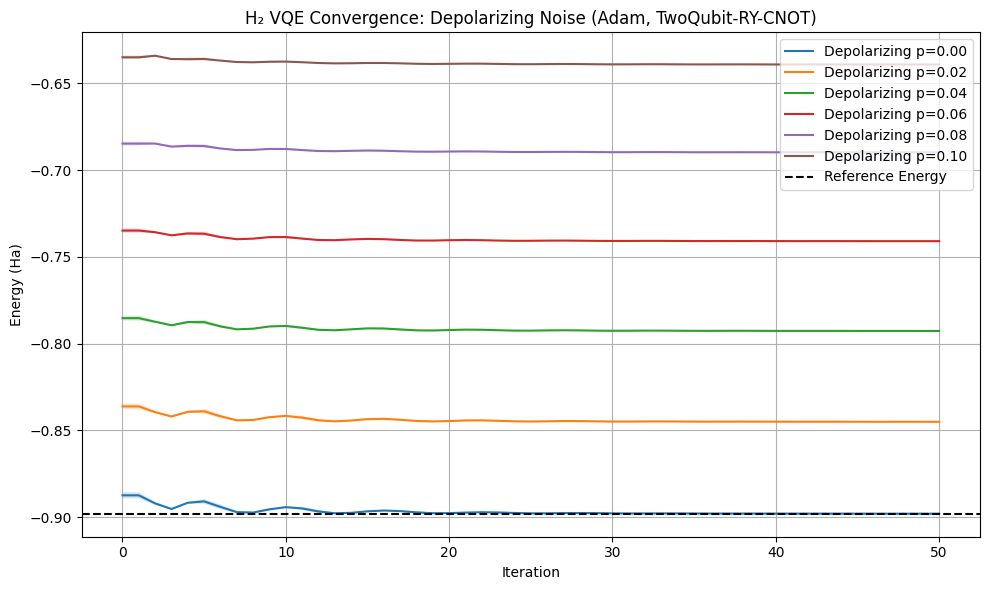

In [32]:
# Pure state and energy from noiseless run
noiseless_results = [run_vqe_with_cache(s, noisy=False, optimizer_name=optimizer_name) for s in seeds]

# Extract energies and states from the same runs
noiseless_energies = [r[0][-1] for r in noiseless_results]
noiseless_states   = [r[2] for r in noiseless_results]

# Use first state as reference
reference_energy = np.mean(noiseless_energies)
pure_state = noiseless_states[0]

# Plot energy convergence vs iteration for different noise levels
plt.figure(figsize=(10, 6))
noise_type = "Depolarizing"  # or "Amplitude"
for p in noise_levels:
    all_energies = []
    for s in seeds:
        energies, _, _ = run_vqe_with_cache(
            seed=s,
            noisy=True,
            dep_prob=(p if noise_type == "Depolarizing" else 0.0),
            amp_prob=(p if noise_type == "Amplitude" else 0.0),
            optimizer_name=optimizer_name,
        )
        all_energies.append(energies)
    
    # Align length (some runs may have slightly different number of recorded points)
    min_len = min(len(e) for e in all_energies)
    truncated = np.array([e[:min_len] for e in all_energies])
    
    mean_energy = np.mean(truncated, axis=0)
    std_energy = np.std(truncated, axis=0)
    
    plt.fill_between(range(min_len),
                     mean_energy - std_energy,
                     mean_energy + std_energy,
                     alpha=0.2)
    plt.plot(range(min_len), mean_energy, label=f"{noise_type} p={p:.2f}")

plt.axhline(reference_energy, color='k', linestyle='--', label='Reference Energy')
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title(f"H₂ VQE Convergence: {noise_type} Noise ({optimizer_name}, {ansatz_desc})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_{noise_type}_Convergence_{optimizer_name}_{ansatz_desc}.png", dpi=300)
plt.show()


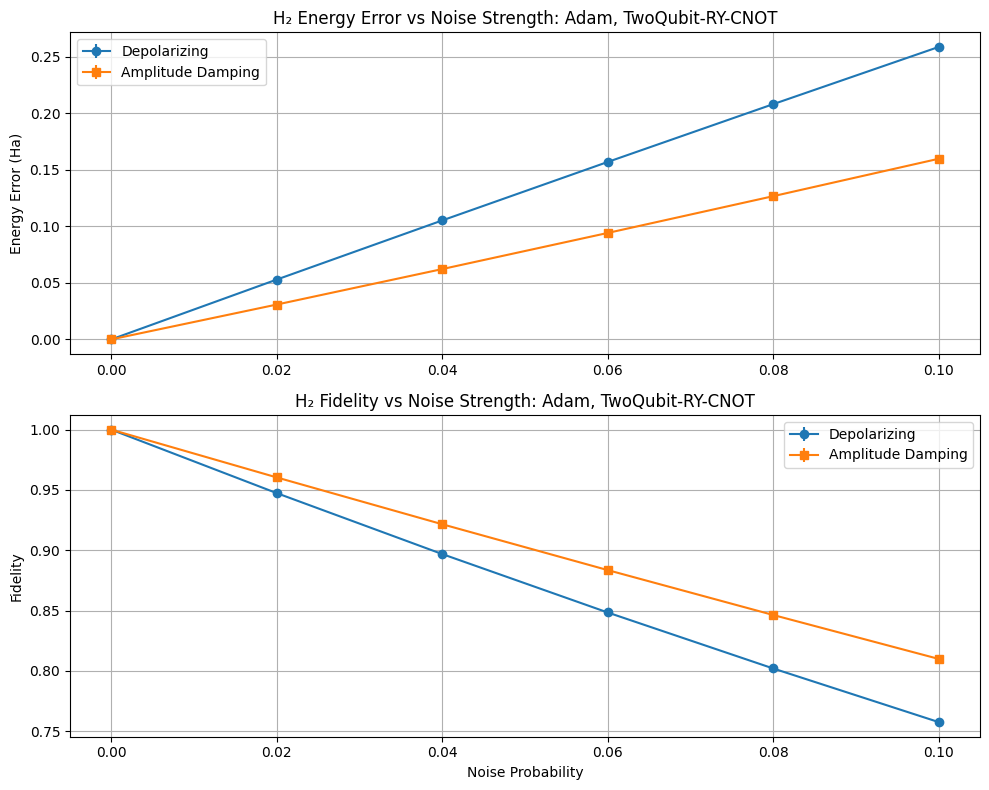

In [33]:
# Depolarizing results
energy_errors_dep, energy_error_stds_dep, fidelity_means_dep, fidelity_stds_dep = compute_noise_stats(
    noise_levels, dep_prob=1, amp_prob=0, optimizer_name=optimizer_name)

# Amplitude damping results
energy_errors_amp, energy_error_stds_amp, fidelity_means_amp, fidelity_stds_amp = compute_noise_stats(
    noise_levels, dep_prob=0, amp_prob=1, optimizer_name=optimizer_name)

# Energy subplot
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.errorbar(noise_levels, energy_errors_dep, yerr=energy_error_stds_dep, fmt='o-', label='Depolarizing')
plt.errorbar(noise_levels, energy_errors_amp, yerr=energy_error_stds_amp, fmt='s-', label='Amplitude Damping')
plt.ylabel("Energy Error (Ha)")
plt.title(f"H₂ Energy Error vs Noise Strength: {optimizer_name}, {ansatz_desc}")
plt.legend()
plt.grid(True)

# Fidelity subplot
plt.subplot(2,1,2)
plt.errorbar(noise_levels, fidelity_means_dep, yerr=fidelity_stds_dep, fmt='o-', label='Depolarizing')
plt.errorbar(noise_levels, fidelity_means_amp, yerr=fidelity_stds_amp, fmt='s-', label='Amplitude Damping')
plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title(f"H₂ Fidelity vs Noise Strength: {optimizer_name}, {ansatz_desc}")
plt.legend()
plt.grid(True)

# Save and show plot
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_Error_{optimizer_name}_{ansatz_desc}.png", dpi=300)
plt.show()


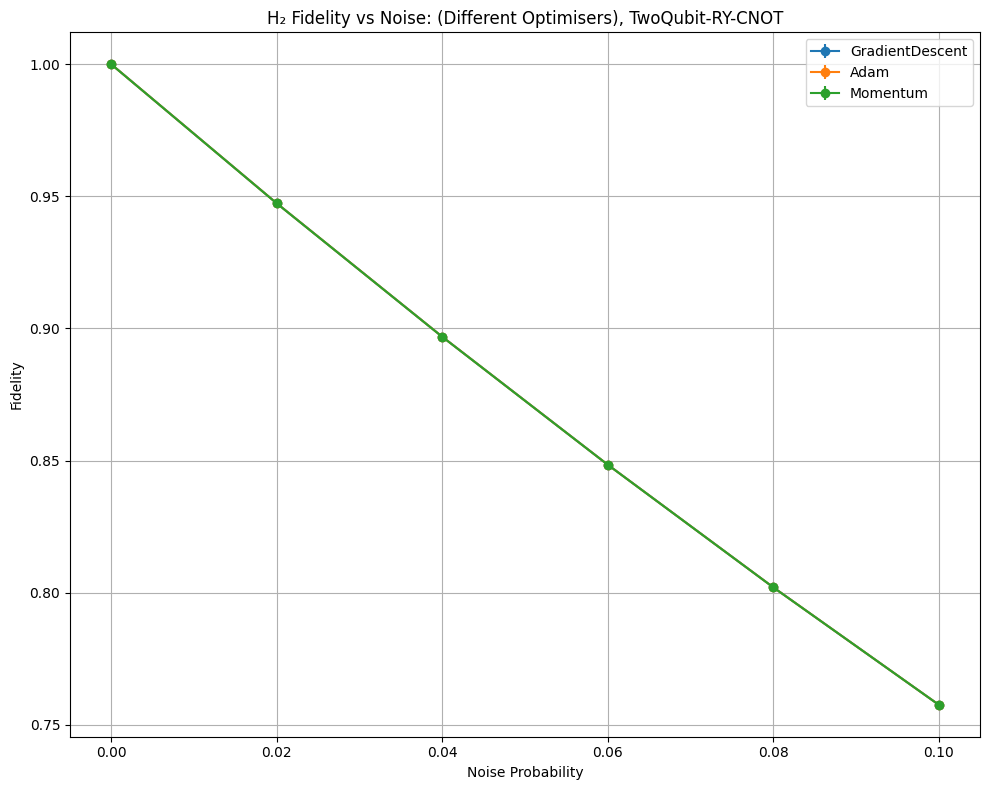

In [34]:
# Plot optimiser comparison under depolarizing noise only
optimizers_to_test = ["GradientDescent", "Adam", "Momentum"]
plt.figure(figsize=(10,8))
for opt_name in optimizers_to_test:
    # Depolarizing only
    energy_errs, energy_err_stds, fidelities, fidelity_stds = compute_noise_stats(
        noise_levels, dep_prob=1, amp_prob=0, optimizer_name=opt_name)
    plt.errorbar(noise_levels, fidelities, yerr=fidelity_stds, fmt='o-', label=f'{opt_name}')
    
plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title(f"H₂ Fidelity vs Noise: (Different Optimisers), {ansatz_desc}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_Error_Optimizer_Comparison_{ansatz_desc}.png", dpi=300)
plt.show()


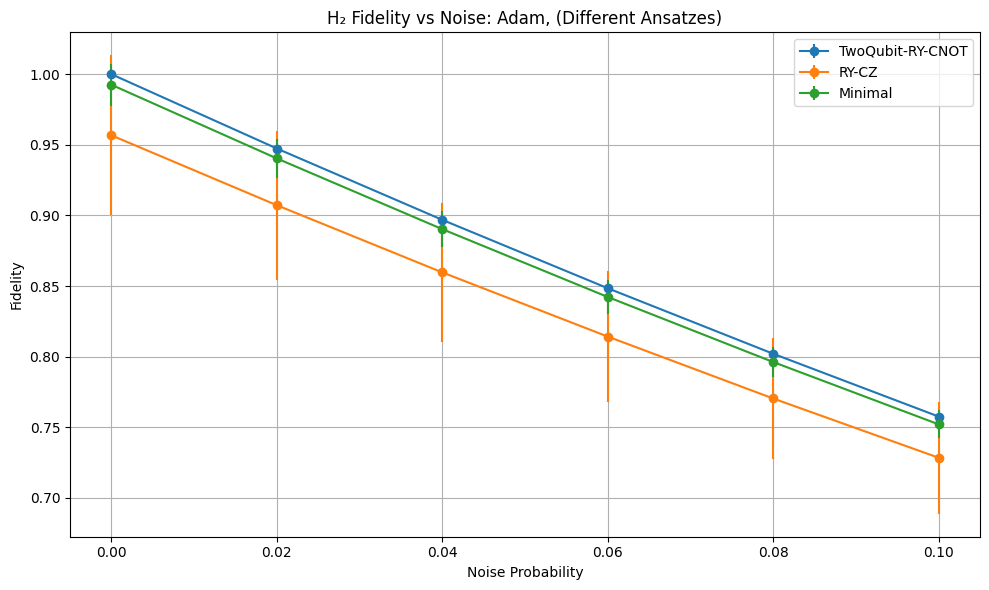

In [35]:
# Plot ansatz comparison under depolarizing noise only
plt.figure(figsize=(10, 6))
for ansatz_name in ANSATZES:
    # Pure state and energy from noiseless run
    noiseless_results = [run_vqe_with_cache(s, noisy=False, optimizer_name=optimizer_name, ansatz_name=ansatz_name) for s in seeds]

    # Extract energies and states from the same runs
    noiseless_energies = [r[0][-1] for r in noiseless_results]
    noiseless_states   = [r[2] for r in noiseless_results]

    # Use first state as reference
    reference_energy = np.mean(noiseless_energies)
    pure_state = noiseless_states[0]

    _, _, fid_means, fid_stds = compute_noise_stats(
        noise_levels, ansatz_name=ansatz_name, dep_prob=1, amp_prob=0, optimizer_name=optimizer_name
    )
    plt.errorbar(noise_levels, fid_means, yerr=fid_stds, fmt='o-', label=ansatz_name)

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title(f"H₂ Fidelity vs Noise: {optimizer_name}, (Different Ansatzes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_Error_Ansatz_Comparison_{optimizer_name}.png", dpi=300)
plt.show()
